# ConvNet on mHealth dataset

In this notebook, we explore the mHealth dataset available from the UCI ML repository [here](https://archive.ics.uci.edu/ml/datasets/MHEALTH+Dataset).

Some of the utilities for processing the data is found in the `utils` folder. Below is a summary of what utils achieve:

We need to process the input data so that it has the shape `(N, seq_len, n_channels)` where `seq_len` is the desired sequence length and `n_channels` is the number of measurement channels (23 here). `N` is the number of blocks times the number of subjects (10 here). The whole data is a very long sequence for each subject, so we divide it into blocks of length `seq_len`. Then, from a given data for a subject, we obtain `L/seq_len` samples (`L` is the original length of data). Multiplying `L/seq_len` by the number of subjects gives us `N`.  

After the data is recast in the tensor form with shape `(N, seq_len, n_channels)`, we can feed it into tensorflow.

In [1]:
# Imports
from utils.utils import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Assuming that we have already processed the data and constructed the desired tensor format, we can go ahead and read the data. Otherwise, the following lines of code will process the data

```python
collect_save_data(block_size=seq_len)
```

the default value of `block_size` is 100.

In [2]:
# Read 
X = np.load('./data/dataX.npy')
Y = np.load('./data/dataY.npy')

In [3]:
print("Number of instances: ", X.shape[0])
print("Length of sequence: ", X.shape[1])
print("Number of channels: ", X.shape[2])

Number of instances:  3355
Length of sequence:  100
Number of channels:  23


Let's split into a training/validation/test set, standardize them and then one-hot encode the labels:

In [3]:
# Train/test
X_tr, X_test, Y_tr, Y_test = train_test_split(X,Y, test_size=0.3, stratify=Y, random_state=123)

# Standardize
X_tr = standardize(X_tr); X_test = standardize(X_test)

# Train/validation
X_train, X_valid, Y_train, Y_valid = train_test_split(X_tr, Y_tr, test_size=0.4, stratify=Y_tr, random_state=456)

# One-hot encode
y_train = one_hot(Y_train, n_class=12)
y_valid = one_hot(Y_valid, n_class=12)
y_test = one_hot(Y_test, n_class=12)

In [4]:
print("Training set size: ", len(X_train))
print("Validaton set size: ", len(X_valid))
print("Test set size: ", len(X_test))

Training set size:  1408
Validaton set size:  940
Test set size:  1007


## Build the model with Tensorflow

In [5]:
# Imports
import tensorflow as tf

# Hyperparameters
batch_size = 400       
seq_len = 100       
learning_rate = 0.0001
epochs = 1000

n_classes = 12
n_channels = 23

# Placeholders
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Now, build the covolutional layers:

In [6]:
with graph.as_default():
    # (batch, 100, 23) --> (batch, 50, 46)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=46, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 50, 46) --> (batch, 25, 92)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=92, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 25, 92) --> (batch, 5, 184)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=184, kernel_size=5, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=5, strides=5, padding='same')

Flatten and pass to the classifier:

In [7]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_3, (-1, 5*184))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


## Train the network

In [ ]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn
    
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_train, y_train, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_valid, y_valid, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/mHealth.ckpt")

## Plots

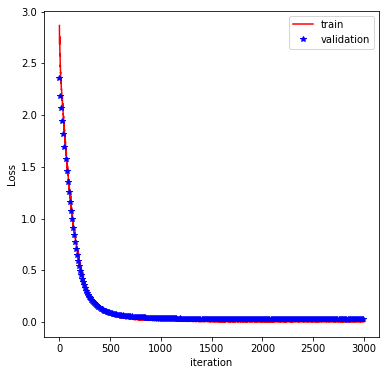

In [9]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

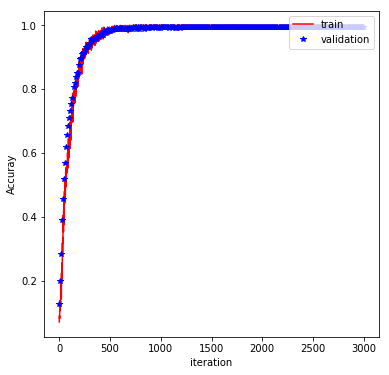

In [10]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [11]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

Test accuracy: 0.993750
